In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [2]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
lag = 41
process = 2


In [3]:
summary_path = f'../{protein}/summary.h5'
hp_paths = ['../../experiments/hpsample.h5', '../../experiments/new_hpsample.h5']
hps = []
for hp_path in hp_paths:
    hp = pd.read_hdf(hp_path)
    hp.reset_index(inplace=True)
    hps.append(hp)
hps = pd.concat(hps)


timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

timescales = timescales.merge(hps, on=['hp_ix'], how='left')
timescales['feature'] = timescales.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

In [4]:
data=timescales.query("process==2").query('lag==41')
data.sort_values(by='median', inplace=True, axis=0, ascending=False)
data['rank'] = (np.arange(data.shape[0])+1).astype(int)

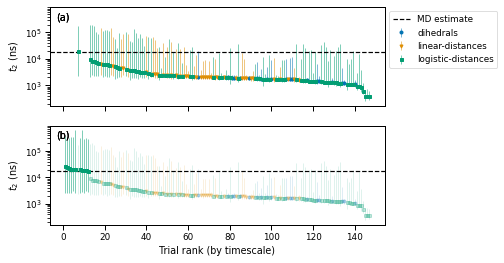

In [24]:
with sns.plotting_context('paper', font_scale=1):
    cols = sns.color_palette('colorblind')
    shapes = ['o', 'v', 's']
    hp_ix_cutoff = 329 # the indices where the optimized trials start
    
    fig, axes = plt.subplots(2, 1, sharey=True, sharex=True)
    for i, feat in enumerate(np.sort(timescales.feature.unique())): 
        # Pre optimization
        ax = axes[0]
        
        ix = (data.feature==feat) & (data.hp_ix < hp_ix_cutoff) 
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], markersize=3, color=cols[i], label=feat)
        
        ax.set_ylabel('$t_{2}$ (ns)')
        ax.set_yscale('log')
        
        ax.annotate(text="(a)", xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
        

         # Post optimization
        ax = axes[1]
        ix = (data.feature==feat) & (data.hp_ix >= hp_ix_cutoff) 
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], markersize=3, color=cols[i], label=feat)
        
        ix = (data.feature==feat) & (data.hp_ix < hp_ix_cutoff) 
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], 
                    markersize=3, color=cols[i], label=feat, alpha=0.25)

        ax.set_xlabel('Trial rank (by timescale)')
        ax.set_ylabel('$t_{2}$ (ns)')
        ax.set_yscale('log')       
        
        ax.annotate(text="(b)", xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
        
    for ax in axes.flatten(): 
        xlim = ax.get_xlim()
        ax.hlines(md_t2[protein], xlim[0], xlim[1], ls='dashed', color='k', label='MD estimate')
        ax.set_xlim(xlim)
        
    
    axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig(f'../{protein}/{protein}_timescales.pdf', bbox_inches='tight')

In [34]:
np.log10(data['median'].min()), np.log10(data['median'].max())

(2.580698985123864, 4.310288484063908)

In [41]:
np.mean(data['ub']>md_t2[protein]), np.sum(data['ub']>md_t2[protein]), 

(0.45588235294117646, 62)

In [43]:
((data['median']/md_t2[protein]-1)*100).head()

54876    13.505258
13291   -46.343708
39868   -55.412951
43327   -55.628429
36375   -56.922939
Name: median, dtype: float64

In [45]:
data['median'].head()

54876    20430.946382
13291     9658.132641
39868     8025.668786
43327     7986.882735
36375     7753.871000
Name: median, dtype: float64